In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import eli5

from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

from sklearn.feature_extraction.text import TfidfVectorizer

from skmultilearn.problem_transform import BinaryRelevance
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import sklearn.metrics as metrics

from gensim import utils
import gensim.parsing.preprocessing as gsp

import joblib

# Functions

# Load data

In [2]:
# Read csv and create list of tags 
df = pd.read_csv('in/StackOverflow_50000_posts.csv')
df = df[['Id', 'Title', 'Body', 'Tags']]

df['Post'] = df['Title'] + ' ' + df['Body']
df.drop(columns = ['Title', 'Body'], inplace = True)

df['Tags'] = df['Tags'].str.findall(r'<(.*?)>')
df['nTags'] = df['Tags'].apply(len)

In [3]:
df = df.loc[0:1999, :]
n_posts = df['Id'].count()

In [4]:
# Create tags matrix of size n_obs * n_tags
mlb = MultiLabelBinarizer(sparse_output = False)
df_tags = pd.DataFrame(mlb.fit_transform(df['Tags']), columns = mlb.classes_, index = df.index)

# Analyze tags

In [5]:
# Sort df_tags per number of occurences 
df_tags_unique = pd.DataFrame(df_tags.sum(axis = 0).sort_values(ascending = False), columns = ['n_occurence'])
df_tags = df_tags[df_tags_unique.index]

In [6]:
# Calculate cumulative percentage of tags
n_total_tags = df_tags.sum().sum()
df_tags_unique['pct_tags'] = df_tags_unique.cumsum(axis = 0) / n_total_tags * 100
n_total_tags

6075

In [7]:
# Calculate what % of posts are covered by at least one tag 
df_tmp = pd.DataFrame(index = df_tags.index, columns = ['Tagged'])
df_tmp['Tagged'] = 0

for col in df_tags:
    df_tmp['Tagged'] = df_tmp['Tagged'] | df_tags[col]
    df_tags_unique.loc[col, 'n_posts'] = df_tmp['Tagged'].sum()
    
df_tags_unique['pct_posts'] = df_tags_unique['n_posts'] / n_posts * 100

# Reset index to create tag col
df_tags_unique = df_tags_unique.reset_index().rename(columns = {'index': 'tag'})

n_tags_unique = df_tags_unique['tag'].count()
n_tags_unique

2104

In [8]:
df_tags_unique

,tag,n_occurence,pct_tags,n_posts,pct_posts
0,python,340,5.596708,340.0,17.00
1,javascript,186,8.658436,525.0,26.25
2,java,161,11.308642,683.0,34.15
3,r,106,13.053498,788.0,39.40
4,c#,95,14.617284,882.0,44.10
...,...,...,...,...,...
2099,ngxs,1,99.934156,2000.0,100.00
2100,ngzone,1,99.950617,2000.0,100.00
2101,nlog,1,99.967078,2000.0,100.00
2102,node-schedule,1,99.983539,2000.0,100.00


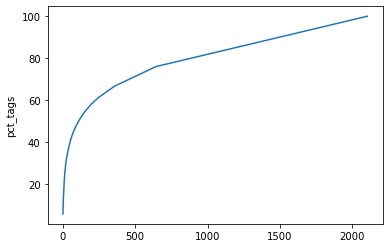

In [9]:
sns.lineplot(x = df_tags_unique.index + 1, y = df_tags_unique['pct_tags'])

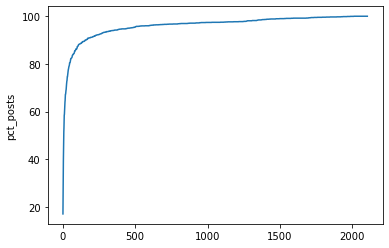

In [10]:
sns.lineplot(x = df_tags_unique.index + 1, y = df_tags_unique['pct_posts'])

In [11]:
df_tags_unique.loc[19, :]

tag             arrays
n_occurence         35
pct_tags       29.2181
n_posts           1352
pct_posts         67.6
Name: 19, dtype: object

# Modelling

In [12]:
list_top = df_tags_unique.loc[0:9, 'tag']

df_tags = df_tags[list_top]

keep_index = df_tags[df_tags.sum(axis = 1) != 0].index

X = df.loc[keep_index, 'Post']
y = df_tags.loc[keep_index, :]

In [13]:
# Define and apply gensim filters
filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.strip_short, 
#            gsp.stem_text
          ]

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    
    s = s.split()
    
    return s

# Custom transformer using gensim filters
class TextCleaner(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

In [14]:
from gensim.corpora import Dictionary

In [15]:
data_lemmatized = TextCleaner().transform(X)

# import gensim.corpora as corpora

# Create Dictionary
id2word = Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [16]:
# Text is in the form of a list of words 
data_lemmatized[55][0:10]

['dplyr',
 'group',
 'respect',
 'drop',
 'false',
 'simple',
 'data',
 'count',
 'problem',
 'grouping']

In [17]:
# Corpus representation counts the frequency of each word in each text 
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 3), (6, 4), (7, 7), (8, 2), (9, 1), (10, 2), (11, 1), (12, 1), (13, 2), (14, 4), (15, 4), (16, 4), (17, 1), (18, 2), (19, 10), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 4), (26, 1), (27, 1), (28, 2), (29, 8), (30, 1), (31, 1), (32, 2), (33, 1), (34, 1), (35, 1), (36, 2), (37, 4), (38, 10), (39, 1), (40, 2), (41, 1), (42, 3), (43, 2), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 15), (51, 3), (52, 1), (53, 4), (54, 1), (55, 5), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 2), (62, 1), (63, 2), (64, 1), (65, 1), (66, 2), (67, 2), (68, 1), (69, 2), (70, 8), (71, 1), (72, 9), (73, 1), (74, 3), (75, 2), (76, 1), (77, 1), (78, 1), (79, 15), (80, 1), (81, 2), (82, 13), (83, 8), (84, 2), (85, 1), (86, 1), (87, 1), (88, 1), (89, 7), (90, 1), (91, 1), (92, 1), (93, 2), (94, 1), (95, 2), (96, 1), (97, 9), (98, 1), (99, 4), (100, 2), (101, 3), (102, 1), (103, 2), (104, 3), (105, 2), (106, 10), (107, 9)]]


In [18]:
from gensim.models import LdaMulticore

In [19]:
# Build LDA model
lda_model = LdaMulticore(corpus = corpus, id2word=id2word, num_topics = 10, random_state = 100, 
                         chunksize = 100, passes = 10, per_word_topics = True)

In [20]:
lda_model.print_topics()

[(0,
  '0.021*"com" + 0.014*"public" + 0.012*"new" + 0.012*"android" + 0.011*"string" + 0.010*"null" + 0.008*"java" + 0.008*"value" + 0.008*"void" + 0.008*"google"'),
 (1,
  '0.020*"org" + 0.019*"java" + 0.009*"jar" + 0.009*"web" + 0.009*"data" + 0.009*"springframework" + 0.008*"release" + 0.007*"numeric" + 0.006*"apache" + 0.006*"security"'),
 (2,
  '0.023*"class" + 0.020*"div" + 0.009*"data" + 0.009*"table" + 0.008*"text" + 0.008*"string" + 0.007*"type" + 0.007*"function" + 0.006*"button" + 0.006*"input"'),
 (3,
  '0.021*"self" + 0.013*"data" + 0.009*"value" + 0.006*"return" + 0.006*"import" + 0.006*"file" + 0.006*"def" + 0.006*"type" + 0.006*"key" + 0.005*"class"'),
 (4,
  '0.015*"model" + 0.008*"view" + 0.007*"function" + 0.007*"class" + 0.007*"new" + 0.006*"true" + 0.006*"div" + 0.006*"return" + 0.005*"code" + 0.005*"image"'),
 (5,
  '0.019*"data" + 0.018*"value" + 0.010*"int" + 0.010*"date" + 0.009*"nan" + 0.009*"file" + 0.009*"column" + 0.008*"type" + 0.007*"import" + 0.006*"tim

In [21]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model = lda_model, texts = data_lemmatized, dictionary = id2word, coherence = 'c_v')

coherence_lda = coherence_model_lda.get_coherence()

print('Coherence Score: ', coherence_lda)

Coherence Score:  0.3669667205771696


In [ ]:
# Evaluate coherence for different values of num_topics
coherence = []
list_num_topics = range(2, 15)

for num_topics in list_num_topics:
    lda_model = LdaMulticore(corpus = corpus, id2word=id2word, num_topics = num_topics, random_state = 100, 
                             chunksize = 100, passes = 10, per_word_topics = True)
    
    coherence_model_lda = CoherenceModel(model = lda_model, texts = data_lemmatized, dictionary = id2word, coherence = 'c_v')

    coherence_lda = coherence_model_lda.get_coherence()
    
    coherence.append(coherence_lda)
    
plt.plot(list_num_topics, coherence, marker = 'o')
# plt.savefig('silhouettes.png', bbox_inches = 'tight')

# Test model in real life conditions

In [22]:
X_test = ['How can I create a super machine learning model using Python and sklearn ?']

In [23]:
X_test_prep = TextCleaner().transform(X_test)

In [24]:
corpus_test = id2word.doc2bow(X_test_prep[0])

In [25]:
lda_model.get_document_topics(corpus_test)

[(0, 0.012513924),
 (1, 0.012512092),
 (2, 0.012517748),
 (3, 0.3197767),
 (4, 0.012515054),
 (5, 0.0125160515),
 (6, 0.012515329),
 (7, 0.012513552),
 (8, 0.58010393),
 (9, 0.012515597)]

In [39]:
lda_model.show_topic(8)

[('import', 0.0100204805),
 ('file', 0.009021684),
 ('python', 0.008376482),
 ('function', 0.008293837),
 ('time', 0.007453044),
 ('code', 0.0068472805),
 ('plot', 0.006626653),
 ('plt', 0.0065597077),
 ('face', 0.0064889044),
 ('list', 0.0058500683)]

In [40]:
lda_model.show_topic(3)

[('self', 0.02125731),
 ('data', 0.013264462),
 ('value', 0.008903139),
 ('return', 0.006462099),
 ('import', 0.0062580584),
 ('file', 0.0062089334),
 ('def', 0.006023722),
 ('type', 0.005928627),
 ('key', 0.0057964916),
 ('class', 0.005263761)]

# Visualize LDA results using pyLDAvis

Warning : pyLDAvis bug in Jupyter Lab causes it to hide toolbar buttons (cf. https://github.com/bmabey/pyLDAvis/issues/162). 

In [34]:
import pyLDAvis
import pyLDAvis.gensim

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
 
LDAvis_prepared